In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pywt import wavedec
import pywt
import numpy as np
import pandas as pd
from scipy.stats import iqr
import sys
import copy
from scipy.signal import detrend
import copy 
import os
import shutil
import pdb
import wfdb


In [2]:
Samp_Freq = 100 
SAMPLES_NUM = 3000

len_coeff = {'cA5': 102, 'cD5': 102, 'cD4': 195, 'cD3': 382, 'cD2': 756, 'cD1': 1504}

#number of bits that can be used to represent the run length. 
len_run = 4

#don't allow the PRD to be greater than 5%
prd_max = 0.4

threshold_approx = 0.999
threshold_D5 = 0.97
threshold_D4toD1 = 0.85

In [3]:
def wave_dec(sig):
    cA5, cD5, cD4, cD3, cD2, cD1 = wavedec(sig, 'bior4.4', level=5)
    coeffs = {'cA5': cA5, 'cD5': cD5, 'cD4': cD4, 'cD3': cD3, 'cD2': cD2, 'cD1': cD1}

    do_plot = False

    if do_plot:
        print('\n\n')
        print('Plot of wavelet decomposition for all levels')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        plt.savefig('wave_dec.png', dpi=150)
        plt.show()

    return coeffs

In [4]:
def coeff_thresholding(coeffs, do_plot=False):
    #make a deep copy of coeffs to retain the original version
    coeffs_orig = copy.deepcopy(coeffs)

    bin_map = {}
    nonzero_coeff_count = {}

    for key in coeffs.keys():
        #sort the absolute value of the coefficients in descending order
        tmp_coeffs = np.sort(np.abs(coeffs[key]))[::-1]

        #calculate the threshold for retaining some percentage of the energy
        if key == 'cA5':
            thresh_perc = threshold_approx
        elif key == 'cD5':
            thresh_perc = threshold_D5
        else:
            thresh_perc = threshold_D4toD1

        energy_thresholded = thresh_perc*energy(tmp_coeffs)
        energy_tmp = 0
        
        #calculate the threshold coefficent value
        for coeff in tmp_coeffs:
            energy_tmp = energy_tmp + coeff**2

            if energy_tmp >= energy_thresholded:
                threshold = coeff
                break

        #set any coefficients below the threshold to zero
        tmp_coeffs = coeffs[key]
        inds_to_zero = np.where((tmp_coeffs < threshold) & (tmp_coeffs > -threshold))[0]
        tmp_coeffs[inds_to_zero] = 0

        #create the binary map
        bin_map_tmp = np.ones(len(coeffs[key])).astype(int)
        bin_map_tmp[inds_to_zero] = 0

        #update the various dictionaries
        coeffs[key] = tmp_coeffs
        bin_map[key] = bin_map_tmp
        nonzero_coeff_count[key] = len(tmp_coeffs)


    if do_plot:
        print('\n\n')
        print('Plot of thresholded vs unthresholded coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_orig['cA5'], label='Original')
        plt.plot(coeffs['cA5'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cA5')
        #print(coeffs['cA5'])

        plt.subplot(6,1,2)
        plt.plot(coeffs_orig['cD5'], label='Original')
        plt.plot(coeffs['cD5'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_orig['cD4'], label='Original')
        plt.plot(coeffs['cD4'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_orig['cD3'], label='Original')
        plt.plot(coeffs['cD3'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_orig['cD2'], label='Original')
        plt.plot(coeffs['cD2'], label='Thresholded')
        plt.legend(loc=1)
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_orig['cD1'], label='Original')
        plt.plot(coeffs['cD1'], label='Thresholded')
        plt.legend(loc=1)
        plt.xlabel('Index')

        plt.tight_layout()
        plt.savefig('wavelet_thresholding.png', dpi=150)
        plt.show()

        
    return coeffs, bin_map

def energy(sig):
    return np.sum(sig**2)

In [5]:
def coeff_scale(coeffs, do_plot=False):
    coeffs_scaled = {}
    scaling_factors = {}
    
    #Function to scale the wavelet coefficients to the [0,1] range. 
    #This involves two scaling factors: a shift factor and a multiplication factor.

    for key in coeffs.keys():
        shift_factor = np.min(coeffs[key])
        coeffs_tmp = coeffs[key]-shift_factor
        #print(shift_factor)

        scale_factor = np.max(coeffs_tmp)
        coeffs_tmp = coeffs_tmp/scale_factor

        scaling_factors[key] = {'shift_factor': shift_factor, 'scale_factor': scale_factor}
        coeffs_scaled[key] = coeffs_tmp


    if do_plot:
        print('\n\n')
        print('Plot of scaled coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_scaled['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs_scaled['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_scaled['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_scaled['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_scaled['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_scaled['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        plt.savefig('wavelet_scaled.png', dpi=150)
        plt.show()


    return coeffs_scaled, scaling_factors

In [6]:
def detrending(sig, do_plot=False):
    detrended = detrend(sig)

    if do_plot:
        print('\n\n')
        print('Original and detrended signal:')
        
        t = [i/Samp_Freq for i in range(SAMPLES_NUM)]
        plt.subplots(figsize=(16,9))
        plt.plot(t, sig, label='Original Signal')
        plt.plot(t, detrended, label='Detrended Signal')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.tight_layout()
        plt.legend(loc=1)
        axes = plt.gca()
        axes.set_xlim((17, 21.5))
        plt.savefig('detrending.png', dpi=150)
        plt.show()

    return detrended



In [7]:
def quantizing(coeffs, bits, do_plot=False):
    
    #Define a function to do quantization. 
    #This function takes in the scaled wavelet coefficients and then multiplies by 2^(num bits), and then rounds to the nearest integer
    
    quantized_coeffs = {}

    for key in coeffs.keys():
        sig = coeffs[key]                     #select the coefficients
        sig = sig*(2**bits-1)                 #multiply by 2^(num bits)
        sig = np.round(sig)                   #round to the nearest integer
        sig = np.array(sig).astype(int)

        quantized_coeffs[key] = sig


    if do_plot:
        print('\n\n')
        print('Plot of quantized coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(quantized_coeffs['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(quantized_coeffs['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(quantized_coeffs['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(quantized_coeffs['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(quantized_coeffs['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(quantized_coeffs['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        plt.savefig('wavelet_quantized.png', dpi=150)
        plt.show()

        
    return quantized_coeffs

In [8]:
def coeff_unscale(coeffs_orig, coeffs_reconstructed, scaling_factors, bits, do_plot=False):
    
    #Define a function to unscale the coefficients back to their original scaling.
    
    coeffs_unscaled = {}

    for key in coeffs_reconstructed.keys():
        tmp_coeffs_unscaled = coeffs_reconstructed[key]/(2**bits)
        tmp_coeffs_unscaled = tmp_coeffs_unscaled*scaling_factors[key]['scale_factor']
        tmp_coeffs_unscaled = tmp_coeffs_unscaled + scaling_factors[key]['shift_factor']

        #now replace the NaN values with 0
        nan_inds = np.where(np.isnan(tmp_coeffs_unscaled))[0]
        tmp_coeffs_unscaled[nan_inds] = 0

        coeffs_unscaled[key] = tmp_coeffs_unscaled


    if do_plot:
        print('\n\n')
        print('Plot of wavelet coefficients before scaling and after rescaling:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_orig['cA5'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cA5'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs_orig['cD5'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD5'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_orig['cD4'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD4'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_orig['cD3'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD3'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_orig['cD2'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD2'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_orig['cD1'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD1'], label='After Rescaling')
        plt.legend(loc=1)
        plt.xlabel('Index')

        plt.tight_layout()
        plt.savefig('wavelet_rescaled.png', dpi=150)
        plt.show()



    return coeffs_unscaled

In [9]:
def wave_recons(coeffs, orig_data, CR, do_plot=False):
    
    #Define a function to do wavelet reconstruction, assuming that the wavelet is a bior4.4 with 5 levels of decomposition
    
    reconstructed = pywt.waverec([coeffs['cA5'], coeffs['cD5'], coeffs['cD4'], coeffs['cD3'], 
                                    coeffs['cD2'], coeffs['cD1']], 'bior4.4')


    if do_plot:
        print('\n\n')
        print('Plot of original signal through the process of compression and decompression:')
        
        t = [i/Samp_Freq for i in range(SAMPLES_NUM)]
        plt.subplots(figsize=(16,9))
        plt.plot(t, orig_data, label='Original Signal')
        plt.plot(t, reconstructed, label='Reconstructed Signal')
        plt.title('Compression Ratio: %.1f' % CR)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.tight_layout()
        plt.legend(loc=1)
        axes = plt.gca()
        axes.set_xlim((17, 21.5))
        plt.savefig('reconstructed.png', dpi=150)
        plt.show()

    return reconstructed

In [10]:
def quant_bits_calc(orig_sig, coeffs_scaled, bin_map, scaling_factors, do_plot=False):
    
    #Define a function to calculate the lowest possible number of bits to quantize the wavelet coefficients such that the PRD is above the threshold.
    
    #starting at 8 bits, keep decreasing the number of bits in the quantization
    #until the PRD is above some threshold
    num_bits = 9

    #initialize PRD to 0 so the while loop can run
    PRD = 0

    #keep track of PRD per number of bits
    PRD_dict = {}

    if do_plot:
        plt.subplots(figsize=(16,9))
        t = [i/Samp_Freq for i in range(SAMPLES_NUM)]
        plt.plot(t, orig_sig, label='Original Signal')


    while (num_bits >= 5) and (PRD <= prd_max):
        #decrement the number of bits
        num_bits = num_bits-1

        coeffs_quantized = quantizing(coeffs_scaled, num_bits)

        #rescale the coefficients
        coeffs_unscaled = coeff_unscale(None, coeffs_quantized, scaling_factors, num_bits)

        #do the inverse dwt
        data_reconstructed = wave_recons(coeffs_unscaled, None, None)

        #calculate PRD
        PRD = prd_calc(orig_sig, data_reconstructed)
        PRD_dict[num_bits] = PRD

        #plot the reconstructed signals 
        if do_plot:
            if PRD <= prd_max:
                plt.plot(t, data_reconstructed, label='Reconstructed @ %i Bits, PRD = %.2f' % (num_bits, PRD))

    #if we went over the PRD, go back up by one bit
    if PRD > prd_max:
        num_bits = num_bits+1
        PRD = PRD_dict[num_bits]

    #plot some more stuff
    if do_plot:
        print('\n\n')
        print('Plots of reconstructed signals vs number of bits used for quantization:')
        plt.legend(loc=1)
        plt.tight_layout()
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        axes = plt.gca()
        axes.set_xlim((17, 21.5))
        plt.savefig('PRD.png', dpi=150)
        plt.show()


    return num_bits, PRD

In [11]:
def coeff_combine(coeffs, bin_map=None):
    
    #Define a function to combine all the wavelet coefficients (and the binary map) in different decomposition levels into one continuous array. 
    #This step is a necessary prerequisite for compression.
    
    coeffs_combined = []

    #loop through each of the wavelet decompositions and remove zero values based 
    #on the binary map
    if bin_map is not None:
        for key in coeffs.keys():
            inds_to_keep = np.where(bin_map[key]==1)[0]
            coeffs[key] = coeffs[key][inds_to_keep]

    #add in each array to coeffs_combined
    coeffs_combined.extend(coeffs['cA5'])
    coeffs_combined.extend(coeffs['cD5'])
    coeffs_combined.extend(coeffs['cD4'])
    coeffs_combined.extend(coeffs['cD3'])
    coeffs_combined.extend(coeffs['cD2'])
    coeffs_combined.extend(coeffs['cD1'])

    return coeffs_combined

In [12]:
def coeff_compress(coeffs, num_bits):
    
    #Define a function to compress the wavelet coefficients.

    binary_string = ''

    for coeff in coeffs:
        #convert each coefficient value to binary in num_bits number of bits
        binary_string = binary_string + format(coeff, '0%ib' % num_bits)

    #loop through sets of 8 bits in the binary string and convert to a byte
    byte_array = []
    for i in range(int(len(binary_string)/8)):
        byte_tmp = binary_string[i*8:(i+1)*8]
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)

    #check if there are any remaining bits that don't divide evenly into 8
    #note the number of bits in this last byte for conversion back to int
    #later on
    num_bits_last_byte = 8
    if len(binary_string)%8 != 0:
        byte_tmp = binary_string[(i+1)*8:(i+1)*8 + len(binary_string)%8]
        num_bits_last_byte = len(byte_tmp)
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)

    return byte_array, num_bits_last_byte

In [13]:
def bin_map_compr(bin_map):
    
    #Define a function to compress the binary map using variable length run-length encoding (RLE)
    
    #The last run count won't be included in the compressed representation, so just append one more value at the end of the binary map to trigger the last compression value. 
    #Make a local deep copy so that the original is not affected
    bin_map = copy.deepcopy(bin_map)
    bin_map.append(int(not bin_map[-1]))


    CURRENT_STATE = bin_map[0]
    run_count = 0
    binary_string = ''

    #loop through each value in the binary map
    for val in bin_map:

        #if the current binary map value is the same as the previous one, just increment the run count
        if val == CURRENT_STATE:
            run_count = run_count + 1

        #otherwise, encode the current run count 
        else:

            #handle cases where run count <= 3
            if run_count == 1:
                binary_string_tmp = '00'

            elif run_count == 2:
                binary_string_tmp = '01'

            elif run_count == 3:
                binary_string_tmp = '10'

            #otherwise, if the run count > 3
            else:
                #calculate the number bits required to represent the run count
                num_bits_run_count = len(format(run_count, 'b'))

                #build a binary string
                binary_string_tmp = ''

                #first bit represents that the run count > 3
                binary_string_tmp = binary_string_tmp + '11'

                #next 4 bits represent the number of bits that will define the run count
                binary_string_tmp = binary_string_tmp + format(num_bits_run_count, '0%ib' % len_run)

                #next number of bits is variable, and is the actual run count
                #may be up to 15 bits assuming len_run=4
                binary_string_tmp = binary_string_tmp + format(run_count, 'b')

            #print(str(run_count) + ', ' + binary_string_tmp)
            #pdb.set_trace()

            #append the binary string
            binary_string = binary_string + binary_string_tmp

            #reset the run count 
            run_count = 1

        #update the current state
        CURRENT_STATE = val


    #convert the binary string into a buffer of 8 bit bytes 
    byte_array = []
    for i in range(int(len(binary_string)/8)):
        byte_tmp = binary_string[i*8:(i+1)*8]
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)


    #check if there are any remaining bits that don't divide evenly into 8
    num_bits_last_byte = 8
    if len(binary_string)%8 != 0:
        byte_tmp = binary_string[(i+1)*8:(i+1)*8 + len(binary_string)%8]
        num_bits_last_byte = len(byte_tmp)
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)


    #return the initial state (ie, the first value in binary map), and the RLE binary map
    return bin_map[0], byte_array, num_bits_last_byte

In [14]:
def bin_map_decompr(bin_map_compressed, bin_map_initial_state, num_bits_last_byte):

    #Define a function to decompress the previously compressed binary map
    
    #first convert 8 bit numbers into a binary string
    binary_string = ''

    #convert each coefficient value to binary in 8 number of bits
    #note that the very last value in the the binary map may not be
    #a full 8 bits. so convert that based on num_bits_last_byte
    bin_map_len = len(bin_map_compressed)
    for i in range(bin_map_len):
        if i == bin_map_len-1:
            binary_string = binary_string + format(bin_map_compressed[i], '0%ib' % num_bits_last_byte)
        else:
            binary_string = binary_string + format(bin_map_compressed[i], '08b')


    #define a state machine that loops through each entry in the binary map and creates the uncompressed representation. 
    READ_HEADER = 0
    READ_NUM_BITS = 1
    READ_RUN_LEN = 2
    state = READ_HEADER

    run_type = bin_map_initial_state
    header = ''
    binary_array = np.array([])


    #loop through each value in the binary map
    for val in binary_string:

        #read the header
        if state == READ_HEADER:
            header = header + val

            if len(header) == 2:
                #run count 1
                if header == '00':
                    binary_array = np.concatenate((binary_array, np.ones(1)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER

                #run count 2
                if header == '01':
                    binary_array = np.concatenate((binary_array, np.ones(2)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER

                #run count 3
                if header == '10':
                    binary_array = np.concatenate((binary_array, np.ones(3)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER
                
                #run count > 3
                if header == '11':
                    state = READ_NUM_BITS
                    num_bits = ''
                #reset header 
                header = ''
            continue

        #read number of bits
        if state == READ_NUM_BITS:
            num_bits = num_bits + val

            if len(num_bits) == 4:
                num_bits_run_len = int(num_bits, 2)
                run_len = ''
                state = READ_RUN_LEN
            continue

        #read run length
        if state == READ_RUN_LEN:
            run_len = run_len + val

            if len(run_len) == num_bits_run_len:
                run_len = int(run_len, 2)
                binary_array = np.concatenate((binary_array, np.ones(run_len)*run_type))
                run_type = int(not run_type)
                state = READ_HEADER
            continue


    return binary_array

In [15]:
def coeff_decompress(coeffs_compressed, num_bits, num_bits_last_byte):

    #Define a function to decompress the previously compressed wavelet coefficients
    
    binary_string = ''

    #convert each coefficient value to binary in 8 number of bits
    #note that the very last value in the the binary map may not be
    #a full 8 bits. so convert that based on num_bits_last_byte
    coeffs_len = len(coeffs_compressed)
    for i in range(coeffs_len):
        if i == coeffs_len-1:
            binary_string = binary_string + format(coeffs_compressed[i], '0%ib' % num_bits_last_byte)
        else:
            binary_string = binary_string + format(coeffs_compressed[i], '08b')


    #loop through sets of num_bits bits in the binary string and convert to a byte
    byte_array = []
    for i in range(int(len(binary_string)/num_bits)):
        byte_tmp = binary_string[i*num_bits:(i+1)*num_bits]
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)


    return byte_array

In [16]:
def coeff_remap(coeffs, bin_map):
    
    #Define a function to map the wavelet coefficients (and the binary map) back to their original decomposition levels.
    
    coeffs_remapped = np.zeros(len(bin_map))*np.nan
    inds_to_set = np.where(bin_map==1)[0]
    coeffs_remapped[inds_to_set] = coeffs

    wavelet_remapped = {}
    counter = 0
    wavelet_remapped['cA5'] = coeffs_remapped[counter:counter+len_coeff['cA5']]

    counter = counter + len_coeff['cA5']
    wavelet_remapped['cD5'] = coeffs_remapped[counter:counter+len_coeff['cD5']]

    counter = counter + len_coeff['cD5']
    wavelet_remapped['cD4'] = coeffs_remapped[counter:counter+len_coeff['cD4']]

    counter = counter + len_coeff['cD4']
    wavelet_remapped['cD3'] = coeffs_remapped[counter:counter+len_coeff['cD3']]

    counter = counter + len_coeff['cD3']
    wavelet_remapped['cD2'] = coeffs_remapped[counter:counter+len_coeff['cD2']]

    counter = counter + len_coeff['cD2']
    wavelet_remapped['cD1'] = coeffs_remapped[counter:counter+len_coeff['cD1']]

    return wavelet_remapped

In [17]:
def coeff_unscale(coeffs_orig, coeffs_reconstructed, scaling_factors, bits, do_plot=False):
    
    #Define a function to unscale the coefficients back to their original scaling
    
    coeffs_unscaled = {}

    for key in coeffs_reconstructed.keys():
        tmp_coeffs_unscaled = coeffs_reconstructed[key]/(2**bits)
        tmp_coeffs_unscaled = tmp_coeffs_unscaled*scaling_factors[key]['scale_factor']
        tmp_coeffs_unscaled = tmp_coeffs_unscaled + scaling_factors[key]['shift_factor']

        #now replace the NaN values with 0
        nan_inds = np.where(np.isnan(tmp_coeffs_unscaled))[0]
        tmp_coeffs_unscaled[nan_inds] = 0

        coeffs_unscaled[key] = tmp_coeffs_unscaled


    if do_plot:
        print('\n\n')
        print('Plot of wavelet coefficients before scaling and after rescaling:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_orig['cA5'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cA5'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs_orig['cD5'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD5'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_orig['cD4'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD4'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_orig['cD3'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD3'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_orig['cD2'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD2'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_orig['cD1'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD1'], label='After Rescaling')
        plt.legend(loc=1)
        plt.xlabel('Index')

        plt.tight_layout()
        plt.savefig('wavelet_rescaled.png', dpi=150)
        plt.show()



    return coeffs_unscaled

In [18]:
def wave_recons(coeffs, orig_data, CR, do_plot=False):
    
    #Define a function to do wavelet reconstruction, assuming that the wavelet is a bior4.4 with 5 levels of decomposition
    
    reconstructed = pywt.waverec([coeffs['cA5'], coeffs['cD5'], coeffs['cD4'], coeffs['cD3'], 
                                    coeffs['cD2'], coeffs['cD1']], 'bior4.4')


    if do_plot:
        print('\n\n')
        print('Plot of original signal through the process of compression and decompression:')
        
        t = [i/Samp_Freq for i in range(SAMPLES_NUM)]
        plt.subplots(figsize=(16,9))
        plt.plot(t, orig_data, label='Original Signal')
        plt.plot(t, reconstructed, label='Reconstructed Signal')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.tight_layout()
        plt.legend(loc=1)
        axes = plt.gca()
        axes.set_xlim((17, 21.5))
        plt.savefig('reconstructed.png', dpi=150)
        plt.show()

    return reconstructed


In [19]:
def compr_ratio_calc(coeffs_compressed, scaling_factors, num_bits, bin_map_compressed, bin_map_initial_state):
    
    #Define a function to calculate the compression ratio. 

    #each value in the compressed coefficients is 8 bits
    num_bits_compressed = len(coeffs_compressed)*8

    #the number of bits in the last byte of the compressed coeffs is 8
    #and another 8 bits for the last byte of the compressed binary map
    num_bits_compressed = num_bits_compressed + 16

    #each set of scaling factors has 2 float values, and each float value is 32 bits
    num_bits_compressed = num_bits_compressed + len(scaling_factors)*2*32

    #the number of bits corresponds to one byte
    num_bits_compressed = num_bits_compressed + 8

    #each value in the compressed binary map is 8 bits
    num_bits_compressed = num_bits_compressed + len(bin_map_compressed)*8

    #the initial state of the binary map is just one bit but assume it's stored as a byte
    num_bits_compressed = num_bits_compressed + 8

    #each of the original data are 16 bits 
    num_bits_uncompressed = SAMPLES_NUM*16

    #get the compression ratio
    compression_ratio = num_bits_uncompressed/num_bits_compressed

    return compression_ratio   

In [20]:
def prd_calc(orig_sig, reconstructed_sig):
    
    #Define a function to calculate the percentage root-mean-square difference (PRD)
    
    num = np.sum((orig_sig - reconstructed_sig)**2)
    den = np.sum(orig_sig**2)

    PRD = np.sqrt(num/den)

    return PRD




Original and detrended signal:


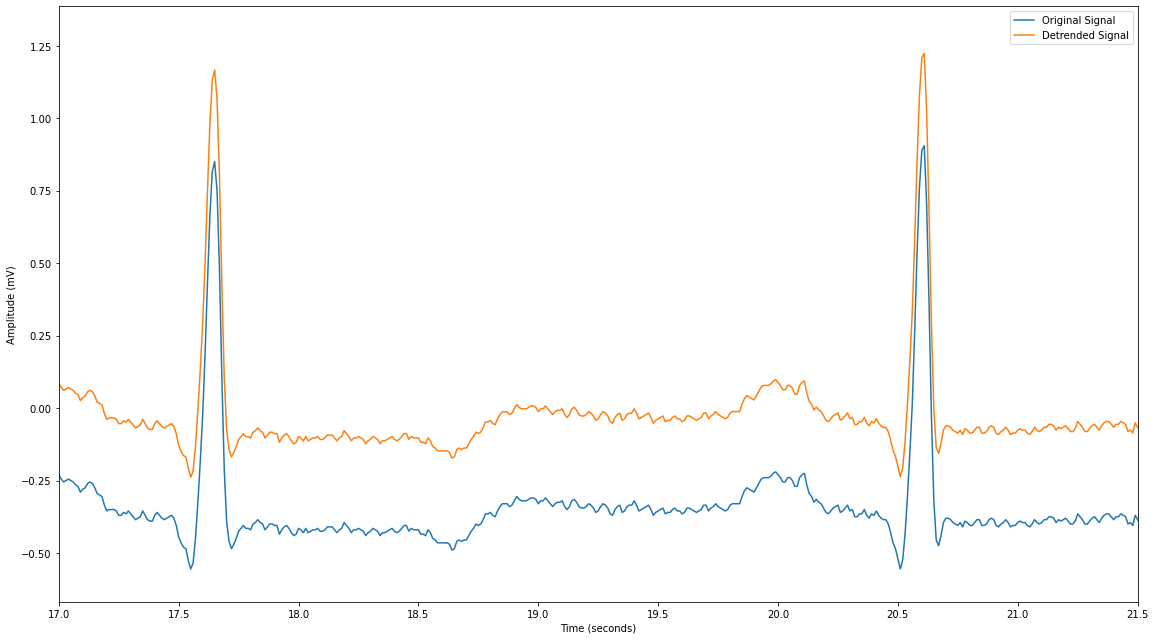




Plot of thresholded vs unthresholded coefficients:


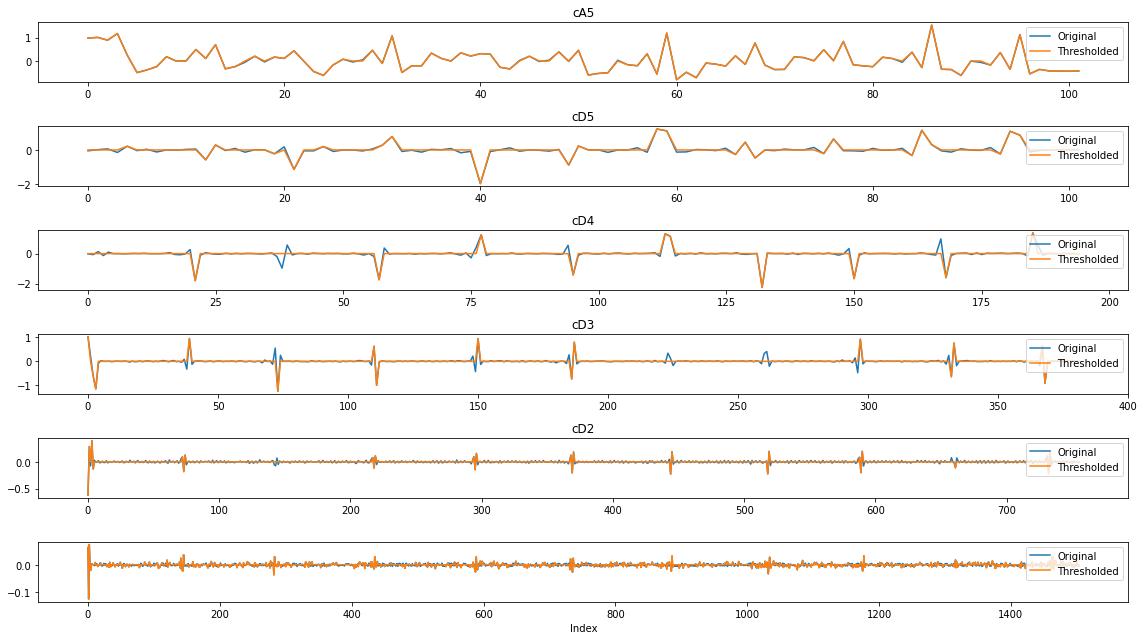




Plot of scaled coefficients:


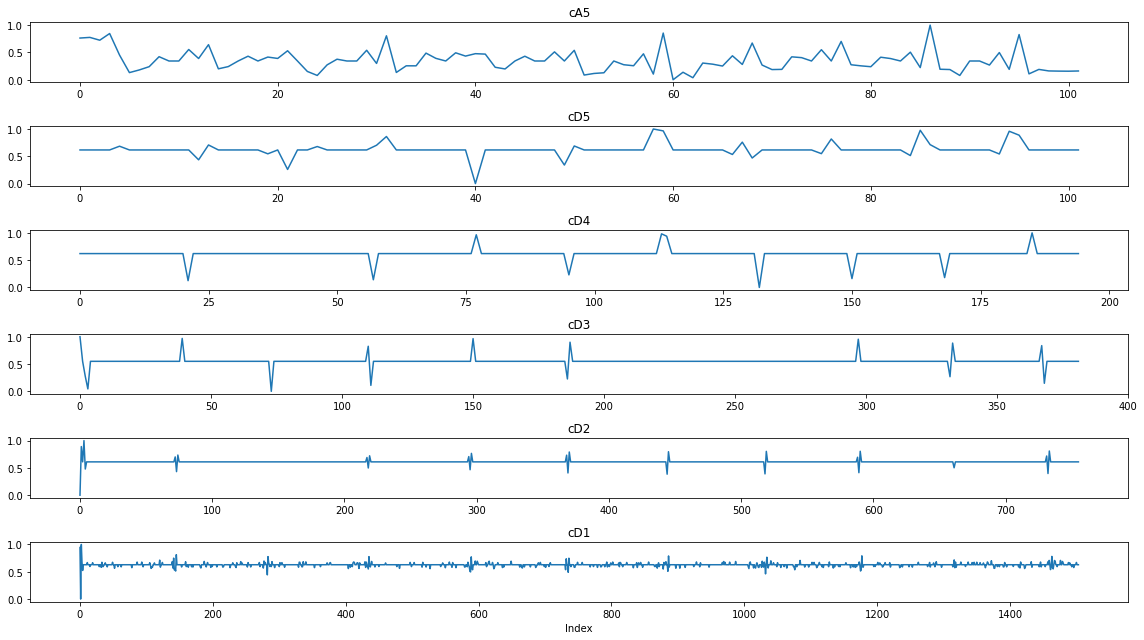




Plots of reconstructed signals vs number of bits used for quantization:


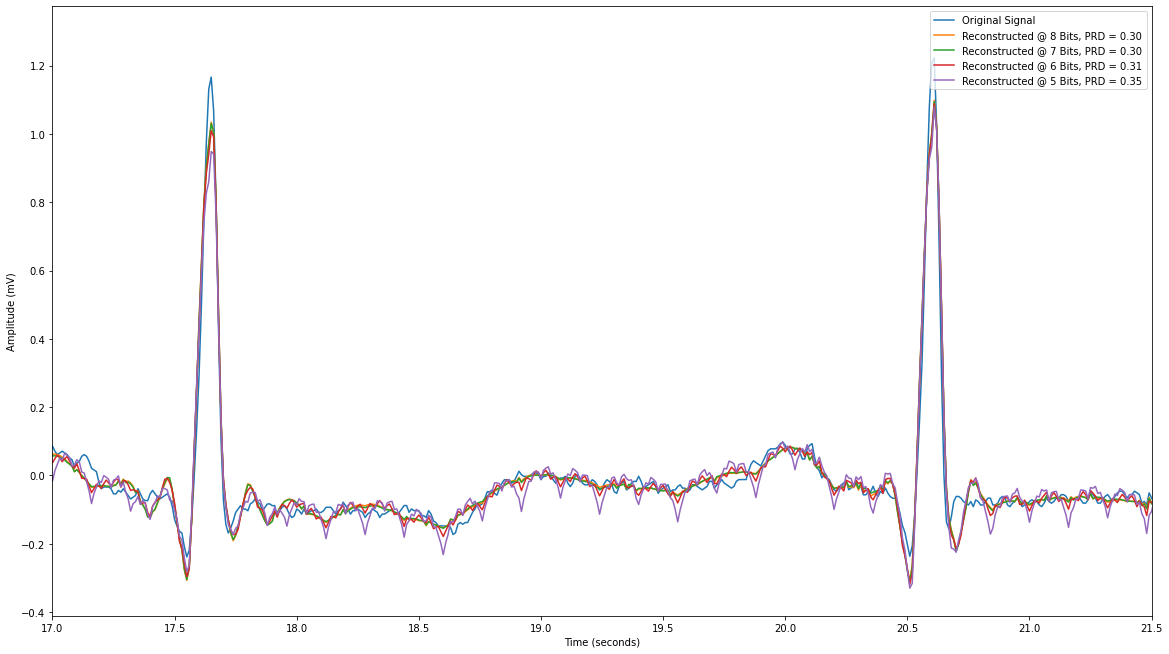




Plot of quantized coefficients:


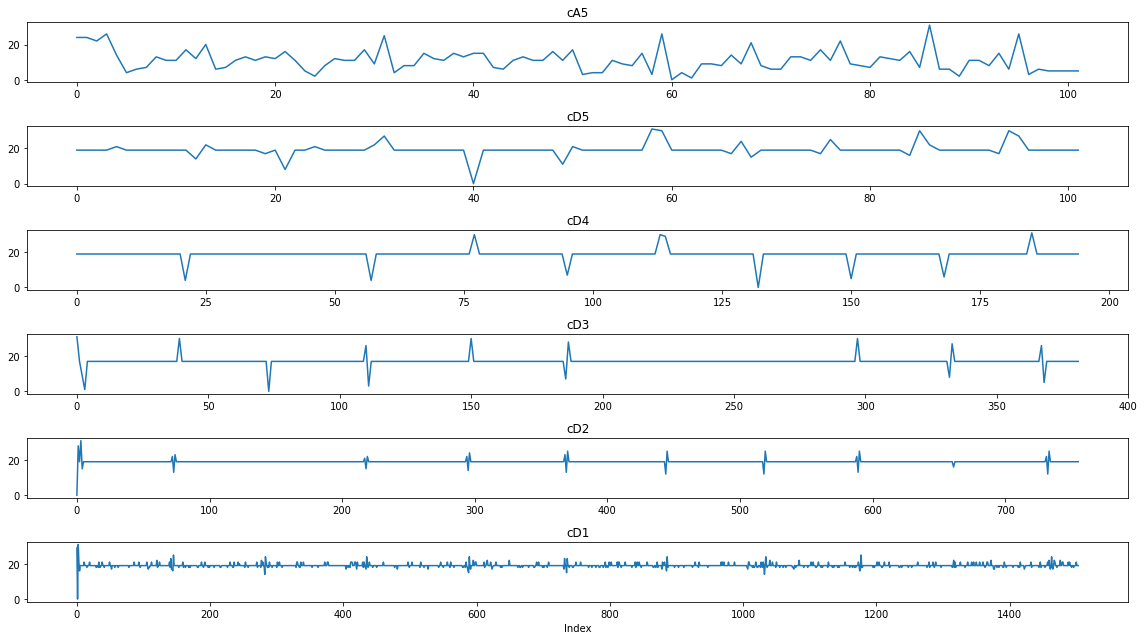




Plot of wavelet coefficients before scaling and after rescaling:


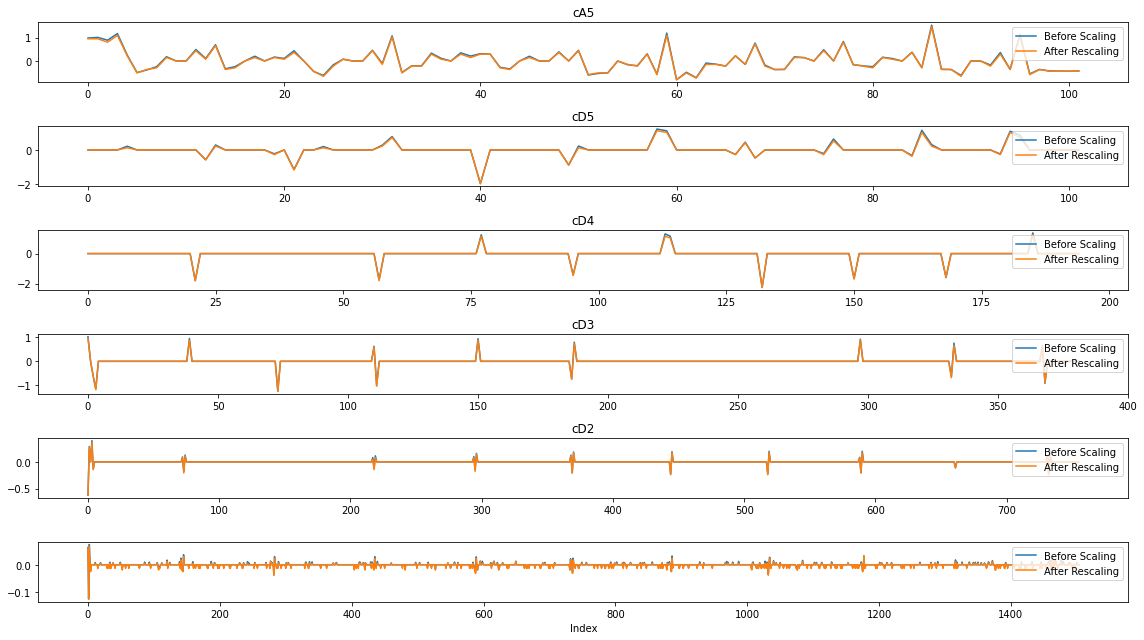




Plot of original signal through the process of compression and decompression:


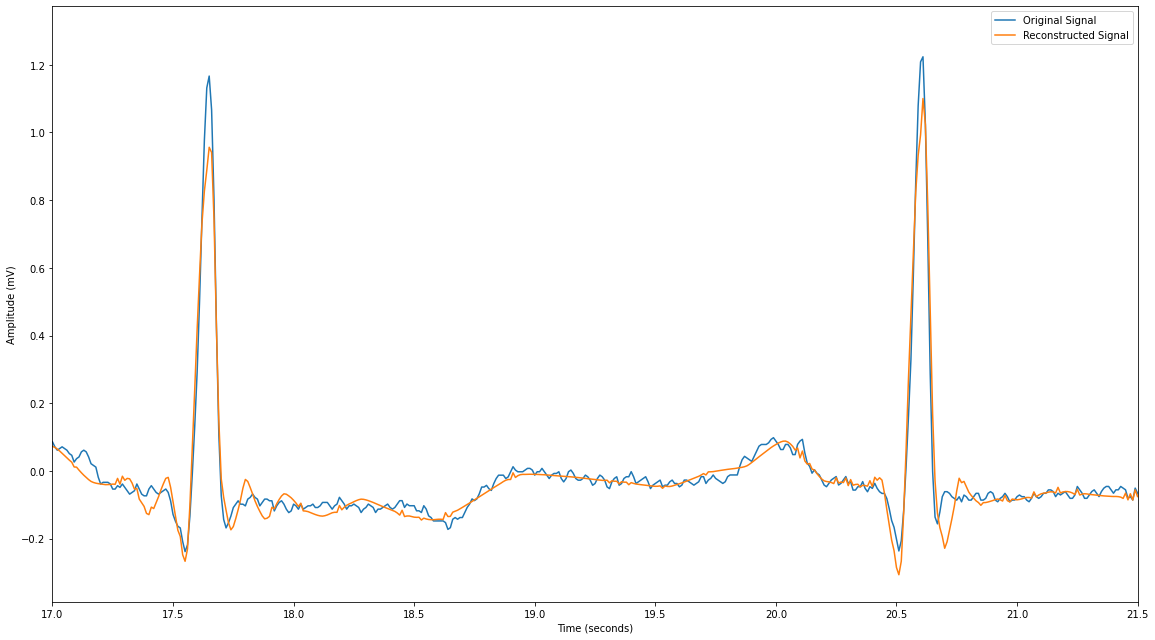

Average compression ratio: 7.9
Average PRD: 0.340


In [22]:
df = pd.read_pickle('100.pkl')

#print(df)

#calculate the number of 10 second non-overlapping blocks of data
N = int(len(df)/SAMPLES_NUM)

#calculate the average CR and average PRD
CR_avg = 0
PRD_avg = 0

#plot stuff
do_plot = True

#loop over the data in 10 second chunks
for i in range(N):
    data = df.loc[i*SAMPLES_NUM:(i+1)*SAMPLES_NUM-1, 0].values
    #print(data)

    #Encoding
    
    data = detrending(data, (i==1))
    coeffs = wave_dec(data)
    coeffs_thresholded, bin_map = coeff_thresholding(coeffs, do_plot=(i==1))
    coeffs_scaled, scaling_factors = coeff_scale(coeffs_thresholded, do_plot=(i==1))
    num_bits, PRD_tmp = quant_bits_calc(data, coeffs_scaled, bin_map, scaling_factors, do_plot=(i==1))
    PRD_avg = PRD_avg + PRD_tmp
    coeffs_quantized = quantizing(coeffs_scaled, num_bits, do_plot=(i==1))
    coeffs_quantized_combined = coeff_combine(coeffs_quantized, bin_map)
    bin_map_combined = coeff_combine(bin_map)
    coeffs_quantized_compressed, num_bits_last_byte_coeffs = coeff_compress(coeffs_quantized_combined, num_bits)
    bin_map_initial_state, bin_map_compressed, num_bits_last_byte_bin_map = bin_map_compr(bin_map_combined)

    #Transmit all the necessary information to reconstruct the signal on the recieving end
    
    #calculate the compression ratio for this transmission
    CR_tmp = compr_ratio_calc(coeffs_quantized_compressed, scaling_factors, num_bits, bin_map_compressed, bin_map_initial_state)
    CR_avg = CR_avg + CR_tmp
    
    #Decoding
    
    bin_map_decompressed = bin_map_decompr(bin_map_compressed, bin_map_initial_state, num_bits_last_byte_bin_map)
    coeffs_decompressed = coeff_decompress(coeffs_quantized_compressed, num_bits, num_bits_last_byte_coeffs)
    coeffs_reconstructed = coeff_remap(coeffs_decompressed, bin_map_decompressed)
    coeffs_unscaled = coeff_unscale(coeffs, coeffs_reconstructed, scaling_factors, num_bits, do_plot=(i==1))
    data_reconstructed = wave_recons(coeffs_unscaled, data, CR_tmp, do_plot=(i==1))
    
#calculate the average compression ratio and PRD
CR_avg = CR_avg/N
PRD_avg = PRD_avg/N
print('Average compression ratio: %.1f' % CR_avg)
print('Average PRD: %.3f' % PRD_avg)


In [23]:
print('Average compression ratio:', CR_avg)
print('Average PRD: ', PRD_avg)

Average compression ratio: 7.892046356175875
Average PRD:  0.340029876390053
